List of sequencial CMAPS colors: https://matplotlib.org/stable/users/explain/colors/colormaps.html 

In [1]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from datasets import load_dataset
from setfit import SetFitModel
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sentence_transformers import SentenceTransformer

In [2]:
# load the original training dataset of the model:
training_dataset = load_dataset("joshuapsa/gpt-generated-news-paragraphs-v1.1")

In [3]:
# convert to df for ease of working:
training_df = pd.DataFrame(training_dataset['train'])

In [4]:
training_df.head(5)

,class_name,text,aviation,cybersecurity,domestic_unrest_violence,extreme_weather,forced_labor,general_biz_trend,individual_accidents_tragedies,later_report,...,maritime,pandemics_large_scale_diseases,railway,strike,trade_war_embargos_bans,transportation_trends_projects,war_conflict,warehouse_fire,class_index,label
0,domestic_unrest_violence,"Buenos Aires, Argentina, grappled with civic u...",0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,aviation,A drone sighting near Amsterdam's Schiphol Air...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,strike,Employees from the entertainment industry are ...,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,individual_accidents_tragedies,The tranquil neighborhood of Cedarwood was sha...,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,6,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,leisure_other_news,Adventure seekers in Summit Peaks are gearing ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."


In [5]:
X_train_text = np.array(training_df['text'])
y_train = np.array(training_df['class_name'])

### 2. Experimenting with a pretrained sentence transformer

In [6]:
# model_name = 'sentence-transformers/paraphrase-albert-small-v2'
model_name = 'sentence-transformers/all-mpnet-base-v2'
st_model = SentenceTransformer(model_name)

In [7]:
X_train = st_model.encode(X_train_text)
# Scale features to [0,1] range
X_train_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_neighbors=20, n_components=2, metric="cosine", random_state=99).fit(X_train_scaled)

c:\Users\JOSHUALE\Documents\Github\mlflow_tutorial\venv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


          X         Y                           label
0  6.771707  1.990757        domestic_unrest_violence
1  2.345444  4.575413                        aviation
2 -2.734411  7.306383                          strike
3 -2.104710  2.775273  individual_accidents_tragedies
4 -4.368778  1.633676              leisure_other_news
sentence-transformers/all-mpnet-base-v2


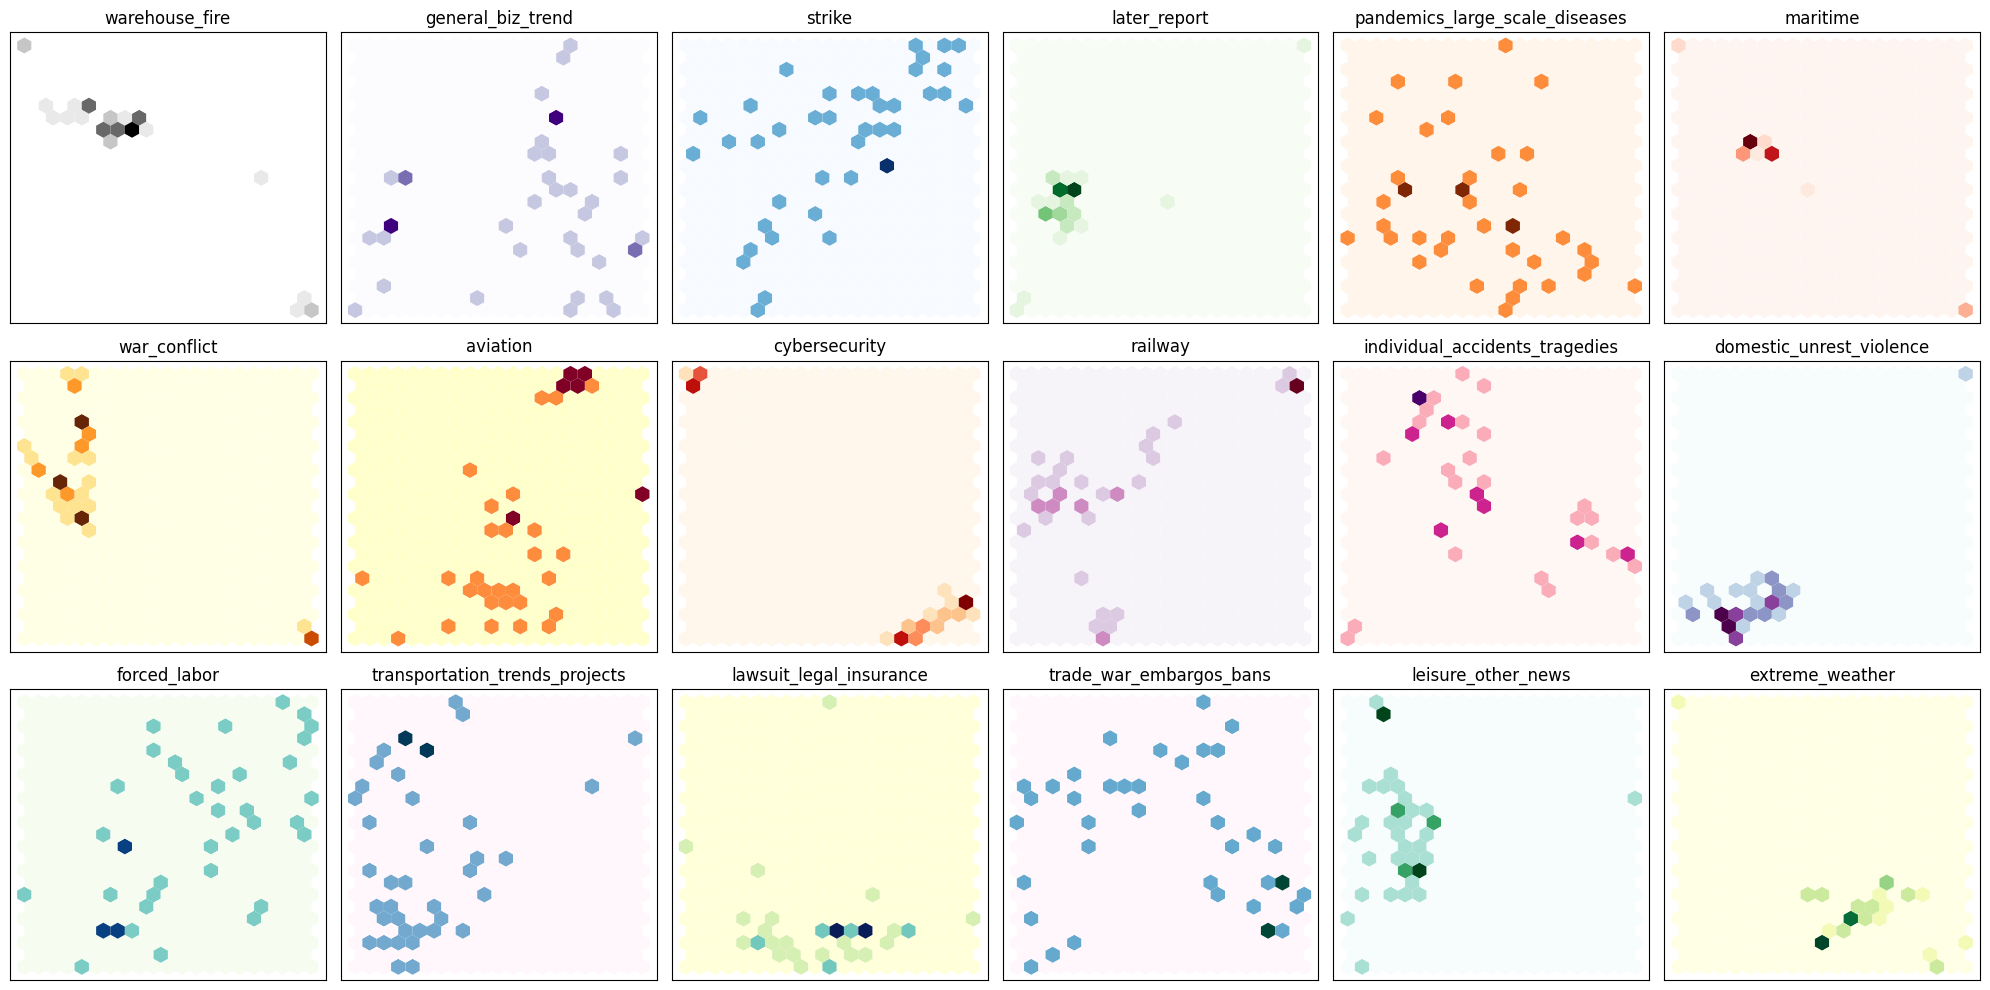

In [113]:
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
print(df_emb.head(5))
print("="*30)

# cmap = plt.get_cmap('viridis')
# colors = cmap(np.linspace(0, 1, len(set(y_train))))
cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

# import matplotlib
# colors_all = list(matplotlib.colors.cnames.keys())

fig, axes = plt.subplots(3, 6, figsize=(20,10))
axes = axes.flatten()
labels = set(y_train)
colors = cmaps[:len(labels)]
print(model_name)
for i, (label, color) in enumerate(zip(labels, colors)):
    df_emb_sub = df_emb.query(f"label == '{label}'")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=color,
    gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()


### 3. Test with another ST model finetuned with setfit

In [93]:
sf_model = SetFitModel.from_pretrained('joshuapsa/setfit-news-topic-paragraphs')
st_model = sf_model.model_body

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
c:\Users\JOSHUALE\Documents\Github\mlflow_tutorial\venv\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.1.1 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\JOSHUALE\Documents\Github\mlflow_tutorial\venv\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.1.1 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\JOSHUALE\Docume

In [94]:
st_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [95]:
X_train = st_model.encode(X_train_text)
# Scale features to [0,1] range
X_train_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_neighbors=20, n_components=2, metric="cosine").fit(X_train_scaled)

           X         Y                           label
0  -1.011764  9.909436        domestic_unrest_violence
1  18.614624 -3.448486                        aviation
2  26.690660 -0.716977                          strike
3   1.609041  4.321179  individual_accidents_tragedies
4  11.697121  7.302919              leisure_other_news


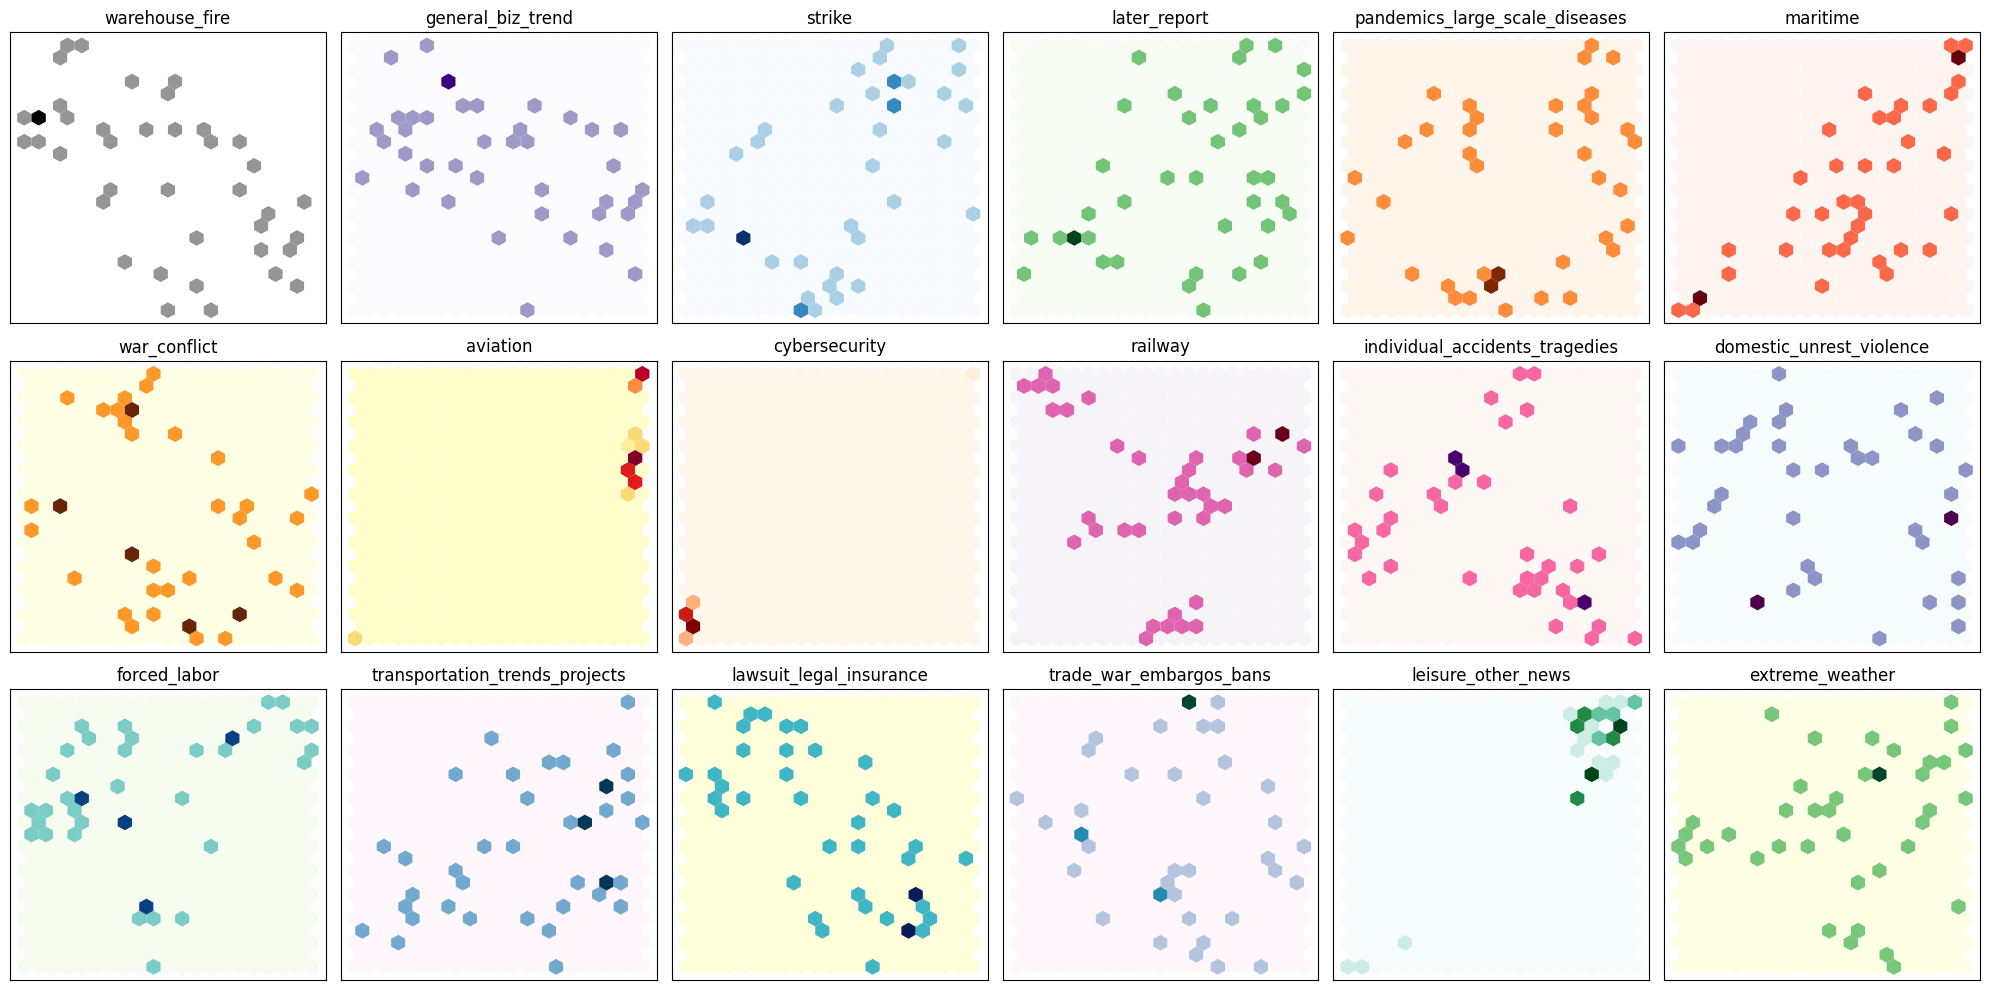

In [96]:
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
print(df_emb.head(5))

# cmap = plt.get_cmap('viridis')
# colors = cmap(np.linspace(0, 1, len(set(y_train))))
cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

# import matplotlib
# colors_all = list(matplotlib.colors.cnames.keys())

fig, axes = plt.subplots(3, 6, figsize=(20,10))
axes = axes.flatten()
labels = set(y_train)
colors = cmaps[:len(labels)]

for i, (label, color) in enumerate(zip(labels, colors)):
    df_emb_sub = df_emb.query(f"label == '{label}'")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=color,
    gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()